In [1]:
import torch, cv2, os, sys, numpy as np, matplotlib.pyplot as plt
from PIL import Image
from ModelZoo.utils import load_as_tensor, Tensor2PIL, PIL2Tensor, _add_batch_one
from ModelZoo import get_model, load_model, print_network
from SaliencyModel.utils import vis_saliency, vis_saliency_kde, click_select_position, grad_abs_norm, grad_norm, prepare_images, make_pil_grid, blend_input
from SaliencyModel.utils import cv2_to_pil, pil_to_cv2, gini
from SaliencyModel.attributes import attr_grad
from SaliencyModel.BackProp import I_gradient, attribution_objective, Path_gradient
from SaliencyModel.BackProp import saliency_map_PG as saliency_map
from SaliencyModel.BackProp import GaussianBlurPath
from SaliencyModel.utils import grad_norm, IG_baseline, interpolation, isotropic_gaussian_kernel

/home/u1657859/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/u1657859/.local/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator12recordStreamERKNS_7DataPtrENS0_10CUDAStreamE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
model = load_model('SwinIR@Base')  # You can Change the model name to load different models
window_size = 16  # Define windoes_size of D
img_lr, img_hr = prepare_images('/work/u1657859/ming0531/DRCT/FeatureVisualization/LAM_Demo/test_images/7.png')  # Change this image name
tensor_lr = PIL2Tensor(img_lr)[:3] ; tensor_hr = PIL2Tensor(img_hr)[:3]
cv2_lr = np.moveaxis(tensor_lr.numpy(), 0, 2) ; cv2_hr = np.moveaxis(tensor_hr.numpy(), 0, 2)

Getting SR Network SwinIR


/home/u1657859/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/u1657859/.local/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Network [SwinIR] was created. Total number of parameters: 11900.2 kelo. To see the architecture, do print(network).
Loading model /work/u1657859/ming0531/DRCT/FeatureVisualization/LAM_Demo/ModelZoo/models/001_classicalSR_DF2K_s64w8_SwinIR-M_x4.pth for SwinIR network.


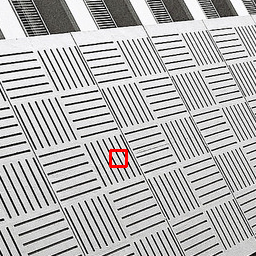

In [3]:
w = 110  # The x coordinate of your select patch, 125 as an example
h = 150  # The y coordinate of your select patch, 160 as an example
         # And check the red box
         # Is your selected patch this one? If not, adjust the `w` and `h`.


draw_img = pil_to_cv2(img_hr)
cv2.rectangle(draw_img, (w, h), (w + window_size, h + window_size), (0, 0, 255), 2)
position_pil = cv2_to_pil(draw_img)
position_pil

In [4]:
sigma = 1.2 ; fold = 50 ; l = 9 ; alpha = 0.5
attr_objective = attribution_objective(attr_grad, h, w, window=window_size)
gaus_blur_path_func = GaussianBlurPath(sigma, fold, l)



interpolated_grad_numpy, result_numpy, interpolated_numpy = Path_gradient(tensor_lr.cpu().numpy(), model, attr_objective, gaus_blur_path_func, cuda=True)

grad_numpy, result = saliency_map(interpolated_grad_numpy, result_numpy)
abs_normed_grad_numpy = grad_abs_norm(grad_numpy)
saliency_image_abs = vis_saliency(abs_normed_grad_numpy, zoomin=4)
saliency_image_kde = vis_saliency_kde(abs_normed_grad_numpy)
blend_abs_and_input = cv2_to_pil(pil_to_cv2(saliency_image_abs) * (1.0 - alpha) + pil_to_cv2(img_lr.resize(img_hr.size)) * alpha)
blend_kde_and_input = cv2_to_pil(pil_to_cv2(saliency_image_kde) * (1.0 - alpha) + pil_to_cv2(img_lr.resize(img_hr.size)) * alpha)
pil = make_pil_grid(
    [position_pil,
     saliency_image_abs,
     blend_abs_and_input,
     blend_kde_and_input,
     Tensor2PIL(torch.clamp(torch.tensor(result), min=0., max=1.))]
)

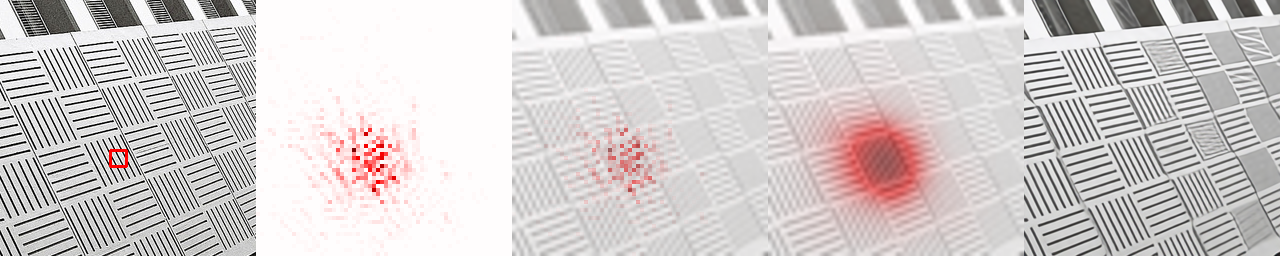

In [5]:
pil

In [6]:
gini_index = gini(abs_normed_grad_numpy)
diffusion_index = (1 - gini_index) * 100
print(f"The DI of this case is {diffusion_index}")

The DI of this case is 15.117547491959748


In [8]:
import torch
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# Assuming `result` and `tensor_hr` are your input PyTorch tensors

# Convert tensors to numpy arrays after clamping, detaching from the graph, and moving to CPU
result_np = torch.clamp(torch.tensor(result), min=0., max=1.).squeeze(0).numpy()
tensor_hr_np = tensor_hr.numpy()

# Calculate PSNR
psnr_value = psnr(result_np, tensor_hr_np, data_range=tensor_hr_np.max() - tensor_hr_np.min())


print(f"PSNR: {psnr_value}")
# Ensure the win_size is appropriately set for the smallest image dimensions
win_size = min(7, *result_np.shape[-2:])  # Adjust based on your actual image sizes

# If your images are very small, consider resizing or ensure win_size is small enough
if result_np.shape[-2] < 7 or result_np.shape[-1] < 7:
    # Example adjustment, though resizing images might be a better approach
    win_size = min(result_np.shape[-2], result_np.shape[-1])
channel_axis = 0

ssim_value = ssim(result_np, tensor_hr_np, win_size=7, data_range=tensor_hr_np.max() - tensor_hr_np.min(), channel_axis=channel_axis)
print(f"SSIM: {ssim_value}")




PSNR: 19.679107818526123
SSIM: 0.6005373597145081


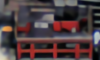

In [9]:
import torch
from PIL import Image

# Assuming 'result' is your input tensor and 'window_size' is defined
window_size = 40 # Define your window_size here

# Convert the tensor to a PIL Image
tensor_clamped = torch.clamp(torch.tensor(result), min=0., max=1.).squeeze(0)
# Assuming the tensor is in CxHxW format and has 3 channels (RGB)
if tensor_clamped.dim() == 3 and tensor_clamped.size(0) == 3:
    # Convert from PyTorch's CxHxW format to HxWxC format expected by PIL
    tensor_clamped = tensor_clamped.permute(1, 2, 0)
tensor_clamped = tensor_clamped.numpy() # Convert to numpy array
tensor_clamped = (tensor_clamped * 255).astype('uint8') # Convert to uint8
image_pil = Image.fromarray(tensor_clamped)

# Calculate the crop coordinates
left = 150 
upper = 140
right = left + 100 # You need to define the width of the crop
lower = upper + 60 # You need to define the height of the crop
crop_box = (left, upper, right, lower)

# Crop the image
cropped_image = image_pil.crop(crop_box)

# To display the cropped image (in a Jupyter notebook, for example)
cropped_image.show()

# If you need to save the cropped image

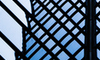

In [ ]:
import torch
from PIL import Image

# Assuming 'result' is your input tensor and 'window_size' is defined
window_size = 40 # Define your window_size here

# Convert the tensor to a PIL Image
tensor_clamped = tensor_hr
# Assuming the tensor is in CxHxW format and has 3 channels (RGB)
if tensor_clamped.dim() == 3 and tensor_clamped.size(0) == 3:
    # Convert from PyTorch's CxHxW format to HxWxC format expected by PIL
    tensor_clamped = tensor_clamped.permute(1, 2, 0)
tensor_clamped = tensor_clamped.numpy() # Convert to numpy array
tensor_clamped = (tensor_clamped * 255).astype('uint8') # Convert to uint8
image_pil = Image.fromarray(tensor_clamped)

# Calculate the crop coordinates
left = 40 
upper = 180
right = left + 100 # You need to define the width of the crop
lower = upper + 60 # You need to define the height of the crop
crop_box = (left, upper, right, lower)

# Crop the image
cropped_image = image_pil.crop(crop_box)

# To display the cropped image (in a Jupyter notebook, for example)
cropped_image.show()

# If you need to save the cropped image